IBM Machine Learning Professional Certificate<br>
__Deep Learning and Reinforcement Learning__

# CNN on Car Detection (VGG vs LeNet)
***

__Author__: Chawit Kaewnuratchadasorn<br>
__Date__: 18th Feb 2022<br>

This notebook was created for Deep Learning and Unsupervised Learning of IBM Machine Learning certificate. The dataset was obtained from Kaggle Dataset by Edward Zhang. The link was attached below. In this notebook, the VGG  and LeNet convolutional neural networks are applied to detect cars in an image. This project aims to learn Region-Based Convolutional Neural Network and learn tensorflow model generation.

Data source: [Car Detection Dataset](https://www.kaggle.com/sshikamaru/car-object-detection)

The contents include:
> 1. Overview of Dataset
> 2. Region-based Processing
> 3. Convolutoinal Neural Networks
>>  VGG<br>
>>  LeNet<br>
> 4. Summary and Future Plan

Firstly, below are all dependencies of this notebook.

In [19]:
# General tools for processing
import os
import numpy as np
import cv2
import pandas as pd

# visualisation tools
import visualkeras
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Tools for preparing
from sklearn.model_selection import train_test_split

# Tools for neural networks
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.losses import categorical_crossentropy

## Overview of Dataset

The dataset has 559 rows and 5 columns, including image file name and rectangular mark of car by two diagonal points. Each image is in another folder. The dataset is in tablular form as seen below.

In [21]:
os.chdir("../../")
data = pd.read_csv("data/train_solution_bounding.csv")
data.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [25]:
os.chdir("data/training_images")

This is the image in the first row of table. The red rectangular mark is drawn from the xmin, ymin, xmax, and ymax on the table. 

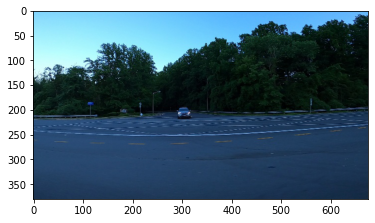

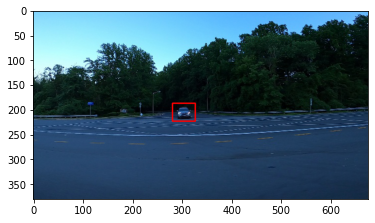

In [28]:
x = data[data["image"] == "vid_4_1000.jpg"]

photo = plt.imread(x["image"][0])
plt.imshow(photo)

pt1=(int(x['xmin'][0]),int(x['ymin'][0]))
pt2=(int(x['xmax'][0]),int(x['ymax'][0]))

color=(255, 0, 0)
thickness = 2
cv2.rectangle(photo, pt1, pt2, color, thickness)
plt.figure()
plt.imshow(photo)

In [4]:
all_photos = []

os.chdir("data/training_images")

for i in data.index:
    photo = plt.imread(data["image"][i])
    all_photos.append(photo)
    
os.chdir("../../")

## Region-based Processing

Here is the idea of object detection in this notebook. Each image file is segmented in to many images by selective search segmentation of OpenCV library. In this section, segmentation and intersection over union will be explained before combining together. The methods were obtained from [this link](https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55)

> Selective Search Segmentation<br>
> Intersect Over Union (IOU)

### Selective Search Segmentation

Each image is segmented as seen below. The green blocks show the segmentation of image number 1000. 

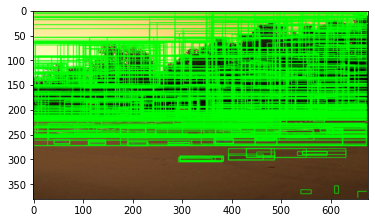

In [5]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

path = "data/training_images"

im = cv2.imread(os.path.join(path,"vid_4_1000.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()

for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

plt.imshow(imOut)

### Intersect Over Union

Each image is calculated for the intersection area. The reference area is the area of xmin, ymin, xmax, and ymax which were obtained from the table. Then, each intersection area is calculated for each segment from selective search segmentation.

In [6]:
def get_iou(bb1, bb2):

    assert bb1['x1'] < bb1['x2'] #bb1
    assert bb1['y1'] < bb1['y2']

    assert bb2['x1'] < bb2['x2'] #bb2
    assert bb2['y1'] < bb2['y2'];

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    assert iou >= 0.0
    assert iou <= 1.0
    
    return iou

Here, this is the combination of selective search segmentation and intersect of union. The image has also been reshaped into 224x224.

In [7]:
image_liste=[]
k=0
l=0
z=0 #Loading
for a in pd.read_csv('data/train_solution_bounding.csv').values:
    Name,xmin,ymin,xmax,ymax=a
    bb1={'x1':int(xmin),'y1':int(ymin),'x2':int(xmax),'y2':int(ymax)}
    try:
        img=cv2.imread('data/training_images/'+Name)
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        for i in rects:
            x, y, w, h = i # Selective bounty boxxes
            bb2={'x1':x,'y1':y,'x2':x+w,'y2':y+h}
            img1=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']] # Crop img
            img1_shape=cv2.resize(img1,(224,224))
            if k<l:
                if 0.5<get_iou(bb1,bb2):  
                    image_liste.append([img1_shape,1])
                    k+=1
            else:
                if 0.5<get_iou(bb1,bb2):  
                    image_liste.append([img1_shape,1])
                    k+=1
                else:
                    image_liste.append([img1_shape,0])
                    l+=1
    except Exception as e:
        print('Error',e)
    z+=1
    print(Name,z,len(rects))

vid_4_1000.jpg 1 1133
vid_4_10000.jpg 2 1426
vid_4_10040.jpg 3 1446
vid_4_10020.jpg 4 1402
vid_4_10060.jpg 5 1475
vid_4_10100.jpg 6 1712
vid_4_10120.jpg 7 1531
vid_4_10140.jpg 8 1630
vid_4_1020.jpg 9 1120
vid_4_1040.jpg 10 1220
vid_4_10480.jpg 11 1714
vid_4_10500.jpg 12 1771
vid_4_10520.jpg 13 1724
vid_4_1060.jpg 14 1323
vid_4_10960.jpg 15 1865
vid_4_10980.jpg 16 1816
vid_4_11000.jpg 17 1770
vid_4_11020.jpg 18 1657
vid_4_11240.jpg 19 1725
vid_4_11260.jpg 20 1912
vid_4_11280.jpg 21 1969
vid_4_11380.jpg 22 1779
vid_4_11400.jpg 23 1851
vid_4_11420.jpg 24 1904
vid_4_11440.jpg 25 1842
vid_4_11900.jpg 26 1973
vid_4_11880.jpg 27 1881
vid_4_11920.jpg 28 1935
vid_4_11940.jpg 29 1917
vid_4_11960.jpg 30 2034
vid_4_11980.jpg 31 2081
vid_4_12000.jpg 32 1848
vid_4_12040.jpg 33 2052
vid_4_12100.jpg 34 1917
vid_4_12060.jpg 35 2009
vid_4_12080.jpg 36 2034
vid_4_12120.jpg 37 1863
vid_4_12140.jpg 38 1665
vid_4_12140.jpg 39 1665
vid_4_12160.jpg 40 1697
vid_4_12160.jpg 41 1697
vid_4_12160.jpg 42 1697
vid_4

vid_4_26500.jpg 336 1303
vid_4_26460.jpg 337 1257
vid_4_26460.jpg 338 1257
vid_4_26460.jpg 339 1257
vid_4_26460.jpg 340 1257
vid_4_26460.jpg 341 1257
vid_4_26460.jpg 342 1257
vid_4_26460.jpg 343 1257
vid_4_26520.jpg 344 1268
vid_4_26520.jpg 345 1268
vid_4_26520.jpg 346 1268
vid_4_26540.jpg 347 1114
vid_4_26540.jpg 348 1114
vid_4_26560.jpg 349 1126
vid_4_26580.jpg 350 1022
vid_4_28220.jpg 351 1508
vid_4_28220.jpg 352 1508
vid_4_28200.jpg 353 1578
vid_4_28200.jpg 354 1578
vid_4_28240.jpg 355 1486
vid_4_28440.jpg 356 1446
vid_4_28840.jpg 357 1680
vid_4_28820.jpg 358 1583
vid_4_28880.jpg 359 1672
vid_4_28860.jpg 360 1724
vid_4_29460.jpg 361 1324
vid_4_29480.jpg 362 1238
vid_4_29500.jpg 363 1270
vid_4_29520.jpg 364 1496
vid_4_29520.jpg 365 1496
vid_4_29540.jpg 366 1375
vid_4_29560.jpg 367 1315
vid_4_29880.jpg 368 1374
vid_4_29880.jpg 369 1374
vid_4_29880.jpg 370 1374
vid_4_29880.jpg 371 1374
vid_4_29900.jpg 372 1349
vid_4_29900.jpg 373 1349
vid_4_29900.jpg 374 1349
vid_4_29920.jpg 375 1414


In [8]:
len(image_liste)

10591

## Convolutional Neural Network

In this section, we will perform two CNN: VGG and LeNet. Then, we will compare the accuracy of them. 

In [9]:
data=[]
data_label=[]
for features,label in image_liste:
    data.append(features)
    data_label.append(label)

In [10]:
data=np.asarray(data)
data_label=np.asarray(data_label)

data.shape
data_label.shape

(10591,)

### Split Test and Train set

In [11]:
x_train,x_val,y_train,y_val=train_test_split(data, data_label, test_size=0.33, random_state=0)

### VGG

In [12]:
base_model=tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')

2022-02-20 14:32:13.942721: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-20 14:32:13.947318: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

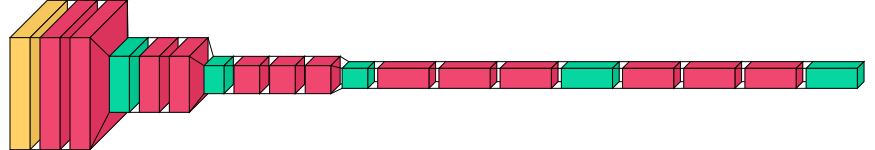

In [14]:
visualkeras.layered_view(base_model, scale_xy=0.5)

In [15]:
model=tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [17]:
base_model.trainable=False

In [18]:
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,'-',layer.trainable)

0 input_1 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - False
16 block5_conv2 - False
17 block5_conv3 - False
18 block5_pool - False


In [19]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [20]:
epoch=3
hist = model.fit(x_train,y_train,epochs=epoch,validation_data=(x_val,y_val))

Train on 7095 samples, validate on 3496 samples
Epoch 1/3
7095/7095 [==============================] - 3537s 499ms/sample - loss: 0.6029 - accuracy: 0.8368 - val_loss: 0.1595 - val_accuracy: 0.9531
Epoch 2/3
7095/7095 [==============================] - 3445s 486ms/sample - loss: 0.2652 - accuracy: 0.9308 - val_loss: 0.1365 - val_accuracy: 0.9688
Epoch 3/3
7095/7095 [==============================] - 5004s 705ms/sample - loss: 0.2106 - accuracy: 0.9388 - val_loss: 0.1227 - val_accuracy: 0.9671


### LeNet

Normally, LeNet is used for black-white image or 32x32x1-shape image. But in this task, we extended LeNet to 32x32x3 because the images we got are in rgb scale. 

In [59]:
image_liste=[]
k=0
l=0
z=0 #Loading
for a in pd.read_csv('data/train_solution_bounding.csv').values:
    Name,xmin,ymin,xmax,ymax=a
    bb1={'x1':int(xmin),'y1':int(ymin),'x2':int(xmax),'y2':int(ymax)}
    try:
        img=cv2.imread('data/training_images/'+Name)
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        for i in rects:
            x, y, w, h = i # Selective bounty boxxes
            bb2={'x1':x,'y1':y,'x2':x+w,'y2':y+h}
            img1=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']] # Crop img
            img1_shape=cv2.resize(img1,(32,32))
            img1_shape = cv2.cvtColor(img1_shape, cv2.COLOR_BGR2GRAY)
            
            if k<l:
                if 0.5<get_iou(bb1,bb2):  
                    image_liste.append([img1_shape,1])
                    k+=1
            else:
                if 0.5<get_iou(bb1,bb2):  
                    image_liste.append([img1_shape,1])
                    k+=1
                else:
                    image_liste.append([img1_shape,0])
                    l+=1
    except Exception as e:
        print('Error',e)
    z+=1
    print(Name,z,len(rects))

vid_4_1000.jpg 1 1133
vid_4_10000.jpg 2 1426
vid_4_10040.jpg 3 1446
vid_4_10020.jpg 4 1402
vid_4_10060.jpg 5 1475
vid_4_10100.jpg 6 1712
vid_4_10120.jpg 7 1531
vid_4_10140.jpg 8 1630
vid_4_1020.jpg 9 1120
vid_4_1040.jpg 10 1220
vid_4_10480.jpg 11 1714
vid_4_10500.jpg 12 1771
vid_4_10520.jpg 13 1724
vid_4_1060.jpg 14 1323
vid_4_10960.jpg 15 1865
vid_4_10980.jpg 16 1816
vid_4_11000.jpg 17 1770
vid_4_11020.jpg 18 1657
vid_4_11240.jpg 19 1725
vid_4_11260.jpg 20 1912
vid_4_11280.jpg 21 1969
vid_4_11380.jpg 22 1779
vid_4_11400.jpg 23 1851
vid_4_11420.jpg 24 1904
vid_4_11440.jpg 25 1842
vid_4_11900.jpg 26 1973
vid_4_11880.jpg 27 1881
vid_4_11920.jpg 28 1935
vid_4_11940.jpg 29 1917
vid_4_11960.jpg 30 2034
vid_4_11980.jpg 31 2081
vid_4_12000.jpg 32 1848
vid_4_12040.jpg 33 2052
vid_4_12100.jpg 34 1917
vid_4_12060.jpg 35 2009
vid_4_12080.jpg 36 2034
vid_4_12120.jpg 37 1863
vid_4_12140.jpg 38 1665
vid_4_12140.jpg 39 1665
vid_4_12160.jpg 40 1697
vid_4_12160.jpg 41 1697
vid_4_12160.jpg 42 1697
vid_4

vid_4_26500.jpg 336 1303
vid_4_26460.jpg 337 1257
vid_4_26460.jpg 338 1257
vid_4_26460.jpg 339 1257
vid_4_26460.jpg 340 1257
vid_4_26460.jpg 341 1257
vid_4_26460.jpg 342 1257
vid_4_26460.jpg 343 1257
vid_4_26520.jpg 344 1268
vid_4_26520.jpg 345 1268
vid_4_26520.jpg 346 1268
vid_4_26540.jpg 347 1114
vid_4_26540.jpg 348 1114
vid_4_26560.jpg 349 1126
vid_4_26580.jpg 350 1022
vid_4_28220.jpg 351 1508
vid_4_28220.jpg 352 1508
vid_4_28200.jpg 353 1578
vid_4_28200.jpg 354 1578
vid_4_28240.jpg 355 1486
vid_4_28440.jpg 356 1446
vid_4_28840.jpg 357 1680
vid_4_28820.jpg 358 1583
vid_4_28880.jpg 359 1672
vid_4_28860.jpg 360 1724
vid_4_29460.jpg 361 1324
vid_4_29480.jpg 362 1238
vid_4_29500.jpg 363 1270
vid_4_29520.jpg 364 1496
vid_4_29520.jpg 365 1496
vid_4_29540.jpg 366 1375
vid_4_29560.jpg 367 1315
vid_4_29880.jpg 368 1374
vid_4_29880.jpg 369 1374
vid_4_29880.jpg 370 1374
vid_4_29880.jpg 371 1374
vid_4_29900.jpg 372 1349
vid_4_29900.jpg 373 1349
vid_4_29900.jpg 374 1349
vid_4_29920.jpg 375 1414


In [60]:
lenet_model = Sequential()
lenet_model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(32,32,1), padding="same"))
lenet_model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
lenet_model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
lenet_model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
lenet_model.add(Flatten())
lenet_model.add(Dense(120, activation='relu'))
lenet_model.add(Dense(84, activation='relu'))
lenet_model.add(Dense(1, activation='softmax'))

lenet_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

lenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 6)         156       
_________________________________________________________________
average_pooling2d_7 (Average (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 16)        2416      
_________________________________________________________________
average_pooling2d_8 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 120)               69240     
_________________________________________________________________
dense_11 (Dense)             (None, 84)               

In [67]:
data=[]
data_label=[]
for features,label in image_liste:
    data.append(features)
    data_label.append(label)
    
data=np.asarray(data)
data_label=np.asarray(data_label)

data = data.reshape([len(image_liste), 32, 32, 1])

In [68]:
x_train,x_val,y_train,y_val=train_test_split(data, data_label, test_size=0.33, random_state=0)

In [69]:
epoch=3
hist = lenet_model.fit(x_train,y_train,epochs=epoch,validation_data=(x_val,y_val))

Train on 7095 samples, validate on 3496 samples
Epoch 1/3
7095/7095 [==============================] - 7s 1ms/step - loss: 7.7001 - accuracy: 0.4978 - val_loss: 7.6008 - val_accuracy: 0.5043
Epoch 2/3
7095/7095 [==============================] - 7s 1ms/step - loss: 7.7001 - accuracy: 0.4978 - val_loss: 7.6008 - val_accuracy: 0.5043
Epoch 3/3
7095/7095 [==============================] - 7s 998us/step - loss: 7.7001 - accuracy: 0.4978 - val_loss: 7.6008 - val_accuracy: 0.5043


In [70]:
visualkeras.layered_view(lenet_model, scale_xy=0.5)

### Test of VGG 

Total Segments:  1515


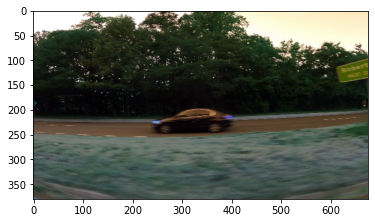

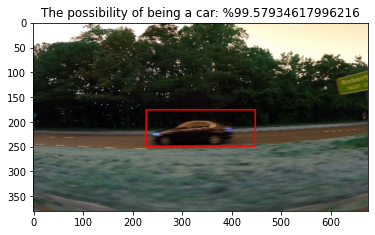

In [38]:
car=[]
image = 'data/testing_images/vid_5_26620.jpg'

predict_image = cv2.imread(image)
ss.setBaseImage(predict_image)
ss.switchToSelectiveSearchFast()
segments = ss.process()

print('Total Segments: ',len(segments))
for i in segments:
    x, y, w, h = i
    bb3 = {'x1':x, 'y1':y, 'x2':x+w, 'y2':y+h}
    try:
        assert bb3['x1'] < bb3['x2']
        assert bb3['y1'] < bb3['y2']
        image_data = predict_image[bb3['y1']:bb3['y2'],bb3['x1']:bb3['x2']]
        image_data = cv2.resize(image_data,(224,224))
        image_data = image_data.astype(np.float32)
        prediction_segment = model.predict(image_data.reshape(1,224,224,3))
        if prediction_segment[0]>0.5:
            car.append([bb3,prediction_segment[0]])
        else:
            pass
        
    except Exception as e:
        print('Error',e)
        print('Possible Cars: ',len(car))
        print('-------------------------------------------------------------------------')

predict_image = cv2.imread(image)
car[np.argmax(np.array(car)[:,1])][0]
pt1 = (car[np.argmax(np.array(car)[:,1])][0]['x1'],car[np.argmax(np.array(car)[:,1])][0]['y1'])
pt2 = (car[np.argmax(np.array(car)[:,1])][0]['x2'],car[np.argmax(np.array(car)[:,1])][0]['y2'])
plt.figure()
plt.imshow(predict_image)
cv2.rectangle(predict_image,pt1,pt2,(255, 0, 0),2)
plt.figure()
plt.title(f'The possibility of being a car: %{car[np.argmax(np.array(car)[:,1])][1][0]*100}')
plt.imshow(predict_image)

### Test of LeNet

Total Segments:  1515


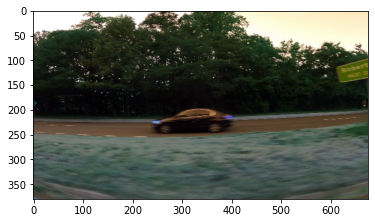

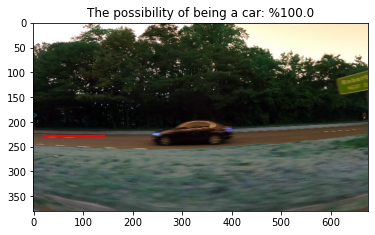

In [66]:
car=[]
image = 'data/testing_images/vid_5_26620.jpg'

predict_image = cv2.imread(image)
ss.setBaseImage(predict_image)
ss.switchToSelectiveSearchFast()
segments = ss.process()

print('Total Segments: ',len(segments))
for i in segments:
    x, y, w, h = i
    bb3 = {'x1':x, 'y1':y, 'x2':x+w, 'y2':y+h}
    try:
        assert bb3['x1'] < bb3['x2']
        assert bb3['y1'] < bb3['y2']
        image_data = predict_image[bb3['y1']:bb3['y2'],bb3['x1']:bb3['x2']]
        image_data = cv2.resize(image_data,(32,32))
        image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)
        image_data = image_data.astype(np.float32)
        prediction_segment = lenet_model.predict(image_data.reshape(1,32,32,1))
        if prediction_segment[0]>0.5:
            car.append([bb3,prediction_segment[0]])
        else:
            pass
        
    except Exception as e:
        print('Error',e)
        print('Possible Cars: ',len(car))
        print('-------------------------------------------------------------------------')

predict_image = cv2.imread(image)
car[np.argmax(np.array(car)[:,1])][0]
pt1 = (car[np.argmax(np.array(car)[:,1])][0]['x1'],car[np.argmax(np.array(car)[:,1])][0]['y1'])
pt2 = (car[np.argmax(np.array(car)[:,1])][0]['x2'],car[np.argmax(np.array(car)[:,1])][0]['y2'])
plt.figure()
plt.imshow(predict_image)
cv2.rectangle(predict_image,pt1,pt2,(255, 0, 0),2)
plt.figure()
plt.title(f'The possibility of being a car: %{car[np.argmax(np.array(car)[:,1])][1][0]*100}')
plt.imshow(predict_image)

### Summary and Future Plan

The VGG performed far better than LeNet on car detection of the given dataset. The accuracy of VGG is at 96 percent while the accuracy of LeNet is at 50 percent. The limitation of my laptop is that running VGG with 224x224 images took around an hour for one epoch. The future development could be trying to play with another model with the increase in speed and accuracy. 

## References

Special Thanks to 

>1. [Step-by-step RCNN](https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55) <br>
>2. [Some codes I obtained from](https://www.kaggle.com/serhanayberkkl/car-detection-rcnn-acc-97/notebook) <br>
>3. [LeNet network](https://www.kaggle.com/curiousprogrammer/lenet-5-cnn-with-keras-99-48#LeNet-5-CNN-with-Keras)<br>
>4. [Neural Network Architecture](https://towardsdatascience.com/5-neural-network-architectures-you-must-know-for-computer-vision-31d2991fe24e)<br>
>5. [Intersection Over Union](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection)